In [1]:
# To extract data from .h5 files and put it into the arrays we need to make the following plots:
# rate vs time, radon vs time, rate vs radon
# The other slow control parameters (humidity, pressure and magnetic field) are also extracted.
# Radon measurements are done with Rad7 which saves its data separately from the other data which uses LabView.
# So Rad7 data from .txt files has to be combined with rate data from .h5 files.

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import os
from glob import glob
import numpy as np
import scipy as scipy
from scipy import stats 
import scipy.optimize as optimize
from scipy.optimize import curve_fit

matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [2]:
# Read in Rad7 data (time and Rn concentration in Bq/m3)
# time of Rad7 is in month/day/year and hour:minute whereas LabView counts in seconds
# 222Rn is measured at one place in the inner box, 
# so it is the same for all sources as far as this measurement is concerned 

dates = {}

for i in range(10):
    dates[i] = {}

#dates[0] = open("RAD7 3072 2016-06-16onlyRnANDtime.txt", 'r') # this dataset was not started at same time as labview
dates[0] = open("RAD7 3072 2016-06-17_2onlyRnANDtime.txt", 'r')
dates[1] = open("RAD7 3072 2016-06-20onlyRnANDtime.txt", 'r')
dates[2] = open("RAD7 3072 2016-06-21onlyRnANDtime.txt", 'r')
dates[3] = open("RAD7 3072 2016-06-22onlyRnANDtime.txt", 'r')
dates[4] = open("RAD7 3072 2016-06-23onlyRnANDtime.txt", 'r')
dates[5] = open("RAD7 3072 2016-06-24onlyRnANDtime.txt", 'r')
dates[6] = open("RAD7 3072 2016-06-26onlyRnANDtime.txt", 'r')
dates[7] = open("RAD7 3072 2016-06-27onlyRnANDtime.txt", 'r')
dates[8] = open("RAD7 3072 2016-06-28onlyRnANDtime.txt", 'r')
dates[9] = open("RAD7 3072 2016-06-29onlyRnANDtime.txt", 'r')

In [3]:
dateTimeAr = []
radonAr = []
dradonAr = []

for date in dates:
    data = dates[date].readlines()
    for line in data:
        data_split = line.split(",")
        dateTimeAr.append(data_split[0])
        radonAr.append(float(data_split[1]))
        dradonAr.append(float(data_split[2]))

In [4]:
# Read in data sets with pandas
#store0616 = pd.HDFStore('ANA_mx_n_20160616_0951.h5') # this dataset was not started at same time as Rad7
store0617 = pd.HDFStore('ANA_mx_n_20160617_0958.h5')
store0620 = pd.HDFStore('ANA_mx_n_20160620_0838.h5')
store0621 = pd.HDFStore('ANA_mx_n_20160621_0826.h5')
store0622 = pd.HDFStore('ANA_mx_n_20160622_0907.h5')
store0623 = pd.HDFStore('ANA_mx_n_20160623_0926.h5')
store0624 = pd.HDFStore('ANA_mx_n_20160624_0946.h5')
store0626 = pd.HDFStore('ANA_mx_n_20160626_0943.h5')
store0627 = pd.HDFStore('ANA_mx_n_20160627_1109.h5')
store0628 = pd.HDFStore('ANA_mx_n_20160628_1045.h5')
store0629 = pd.HDFStore('ANA_mx_n_20160629_1230.h5')

In [5]:
# From analysis/monitor/fitspectrum.C: the energies corresponding to the photopeaks 

fit_values = {}

for i in range(8):
    fit_values[i] = {}

fit_values[0][0] = ('1460 keV','BG')
fit_values[1][0] = ('1460 keV','BG')

fit_values[2][0] = ('511 keV','Ti')
fit_values[3][0] = ('511 keV','Ti')
fit_values[2][1] = ('1157 keV','Ti')
fit_values[3][1] = ('1157 keV','Ti')
fit_values[2][2] = ('511.+1157 keV','Ti')
fit_values[3][2] = ('511.+1157 keV','Ti')


fit_values[4][0] = ('1173 keV','Co')
fit_values[5][0] = ('1173 keV','Co')
fit_values[4][1] = ('1332 keV','Co')
fit_values[5][1] = ('1332 keV','Co')
fit_values[4][2] = ('1332 + 1173 keV','Co')
fit_values[5][2] = ('1332 + 1173 keV','Co')

fit_values[6][0] = ('662 keV','Cs')
fit_values[7][0] = ('662 keV','Cs')

In [6]:
# Definition of needed functions:

# beautifull recursive defaultdict so that automatically all calls that do not excist return a new empty dict
from collections import defaultdict
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)

# Exponential to fit to find A0
def exp(x, A_0): # A_0=activity at t=0 in Bq, and half life time in seconds 
    return A_0*np.exp(-(x*60*60.)*np.log(2)/(half_life_time))

# Function to fit a function to data
def fit_signal(signal, guess, x):
    popt, pcov = curve_fit(exp, x, signal, guess)
    perr = np.sqrt(np.diag(pcov))
    A0 = popt[0]
    errA0 = perr[0]
    Fitted_exp_decay = exp(x, *popt)
    print("Half life time : %s yr" %(half_life_time/(365.25*24*60*60)))
    print("A0 : %s +- %s Bq" %(A0, errA0))
    return Fitted_exp_decay, A0, errA0

# Define residual rate:
def residual(x, exponent_and_modulation_and_noise, fit, plot_function = True):
    residual = (exponent_and_modulation_and_noise) - fit
    return residual

# Fit a gauss to residual histogram
def gauss(x,*p):
    A_g,mu_g, sigma_g = p
    return A_g*np.exp(-(x-mu_g)**2/(2.*sigma_g**2))

In [7]:
# Shows when the data was taken: e.g. data0107: from the 7th of Janaury.
dates = {}
#data0616 = store0616['/ana'] # this dataset was not started at same time as Rad7
data0617 = store0617['/ana']
data0620 = store0620['/ana']
data0621 = store0621['/ana']
data0622 = store0622['/ana']
data0623 = store0623['/ana']
data0624 = store0624['/ana']
data0626 = store0626['/ana']
data0627 = store0627['/ana']
data0628 = store0628['/ana']
data0629 = store0629['/ana']

# pandas datas is needed for "groupby(['channel','peak']))"
datas = pd.concat((data0617,data0620,data0621,data0622,data0623,data0624,data0626,data0627,data0628,data0629))

# make all the values in the data['time'] unique, so only 1 time array is left instead of for all channels and peaks. 
# this means we have 1 array of the time instead of an array with every timemeasurement 16 times = 16 x the same time array parallel. 
# and put time in hours instead of seconds, while we're messing with it anyway

#data0616_time_unique = np.unique(np.array(data0616['time'].values/(60*60))) # this dataset was not started at same time as Rad7
data0617_time_unique = np.unique(np.array(data0617['time'].values/(60*60)))
data0620_time_unique = np.unique(np.array(data0620['time'].values/(60*60)))
data0621_time_unique = np.unique(np.array(data0621['time'].values/(60*60)))
data0622_time_unique = np.unique(np.array(data0622['time'].values/(60*60)))
data0623_time_unique = np.unique(np.array(data0623['time'].values/(60*60)))
data0624_time_unique = np.unique(np.array(data0624['time'].values/(60*60)))
data0626_time_unique = np.unique(np.array(data0626['time'].values/(60*60)))
data0627_time_unique = np.unique(np.array(data0627['time'].values/(60*60)))
data0628_time_unique = np.unique(np.array(data0628['time'].values/(60*60)))
data0629_time_unique = np.unique(np.array(data0629['time'].values/(60*60)))

# Let's assume that when a new run is started there is a timegap of about 30 seconds (estimated from experience).
# When the computer needed a restart the time there was no measurement is written down on Nikhef modulation elog wiki.

#new_data_time_0616 = data0616_time_unique # this dataset was not started at same time as Rad7
#new_data_time_0617 = (data0617_time_unique-(min(data0617_time_unique))+max(data0616_time_unique)+(6./60))
new_data_time_0617 = data0617_time_unique
new_data_time_0620 = (data0620_time_unique-(min(data0620_time_unique))+max(new_data_time_0617)+(6./60))
new_data_time_0621 = (data0621_time_unique-(min(data0621_time_unique))+max(new_data_time_0620)+(4./60))
new_data_time_0622 = (data0622_time_unique-(min(data0622_time_unique))+max(new_data_time_0621)+(3./60))
new_data_time_0623 = (data0623_time_unique-(min(data0623_time_unique))+max(new_data_time_0622)+(2./60))
new_data_time_0624 = (data0624_time_unique-(min(data0624_time_unique))+max(new_data_time_0623)+(6./60))
new_data_time_0626 = (data0626_time_unique-(min(data0626_time_unique))+max(new_data_time_0624)+(3./60))
new_data_time_0627 = (data0627_time_unique-(min(data0627_time_unique))+max(new_data_time_0626)+(3./60))
new_data_time_0628 = (data0628_time_unique-(min(data0628_time_unique))+max(new_data_time_0627)+(2./60))
new_data_time_0629 = (data0629_time_unique-(min(data0629_time_unique))+max(new_data_time_0628)+(5./60))

# add time from all data sets together in one time-array for the combined data
data_time_hours = np.concatenate((new_data_time_0617, new_data_time_0620, new_data_time_0621, new_data_time_0622, new_data_time_0623, new_data_time_0624, new_data_time_0626, new_data_time_0627, new_data_time_0628, new_data_time_0629))

For ('1460 keV', 'BG'):
Half life time : 1251000000.0 yr
A0 : 1.19115554725e+18 +- 1.19112731056e+18 Bq


C:\Users\Dorine\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:2651: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


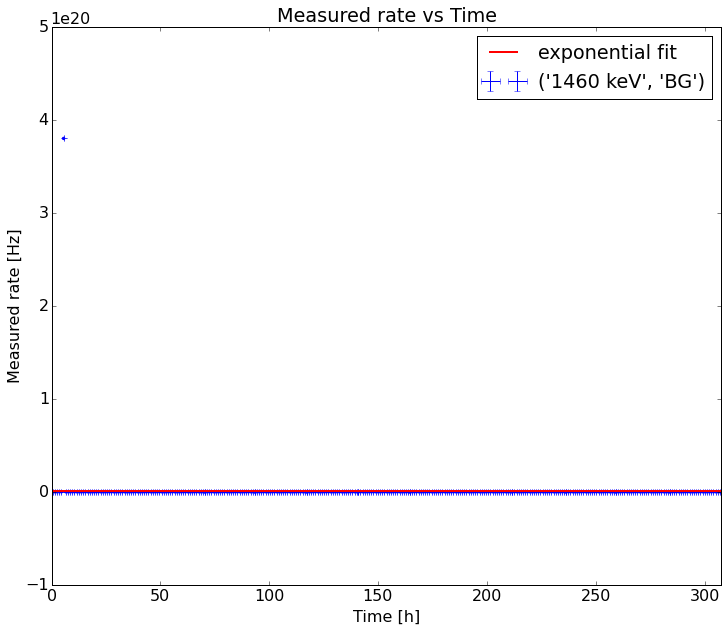

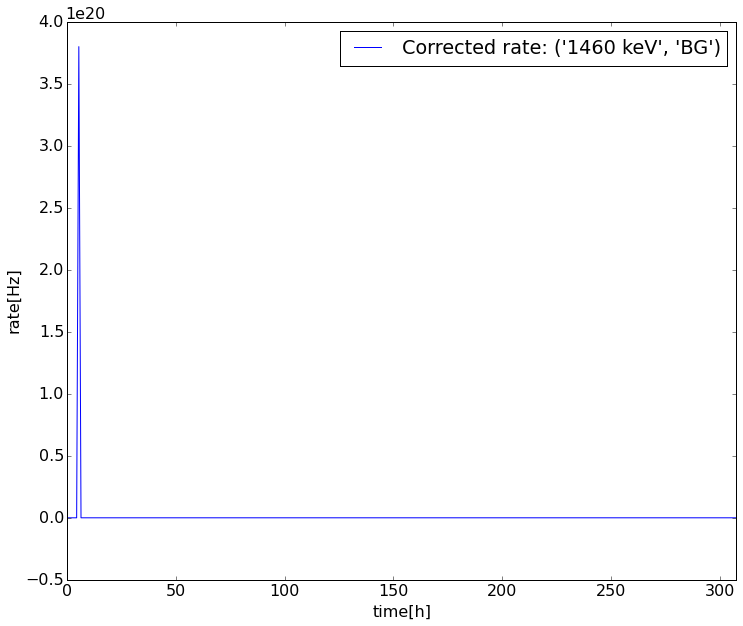

For ('1460 keV', 'BG'):
Half life time : 1251000000.0 yr
A0 : 22.3184613905 +- 23.8766616565 Bq


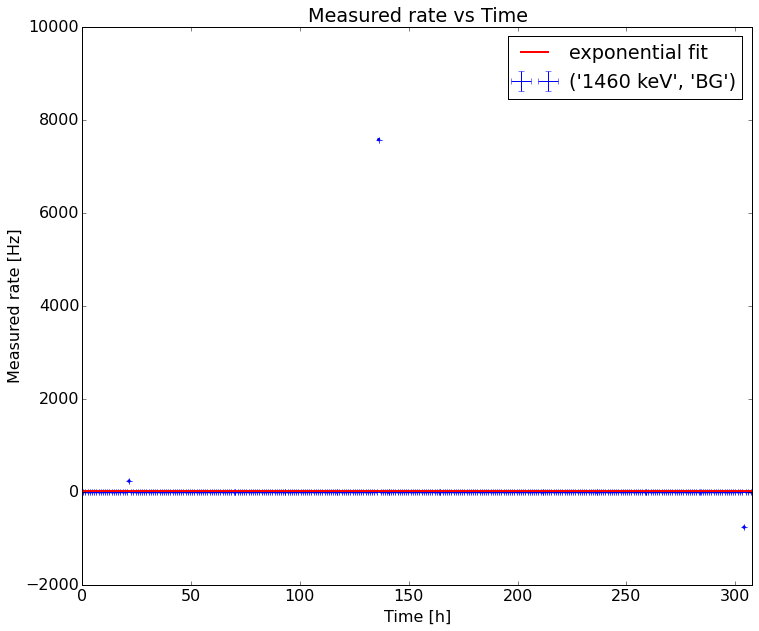

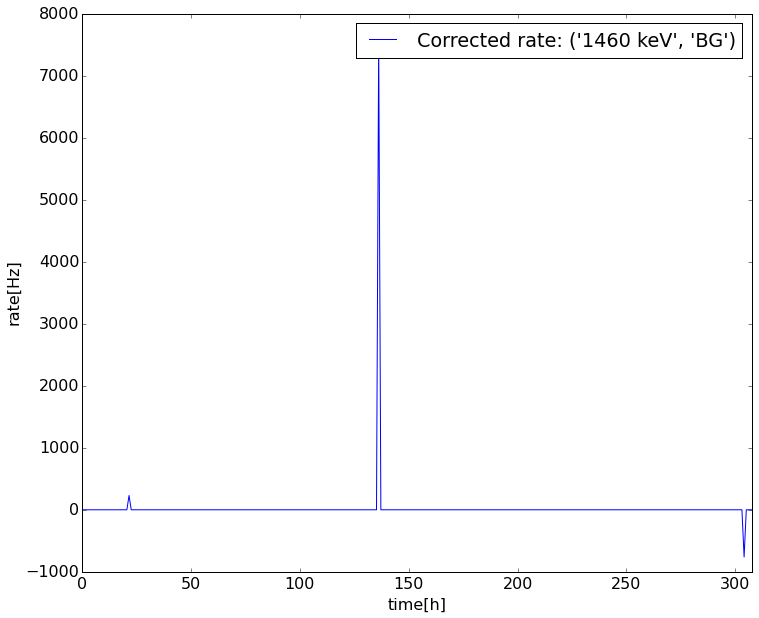

For ('511 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 199.569014308 +- 0.0151728401973 Bq


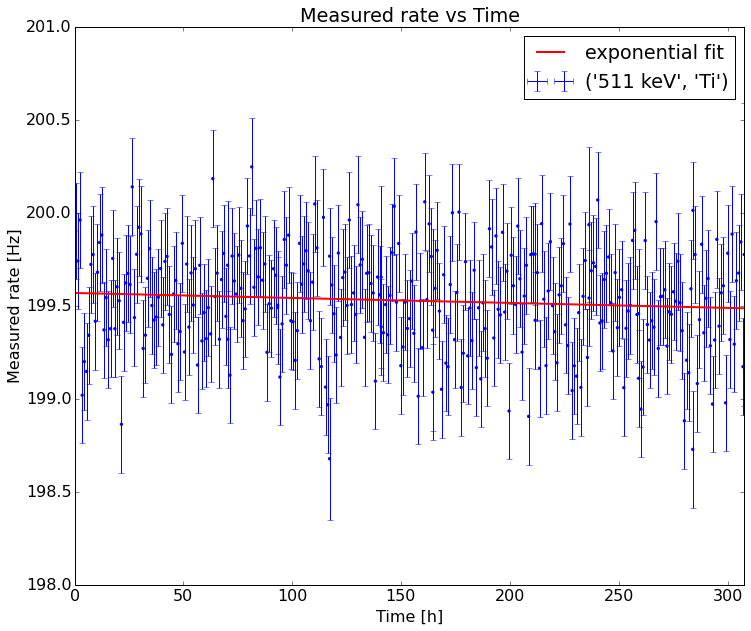

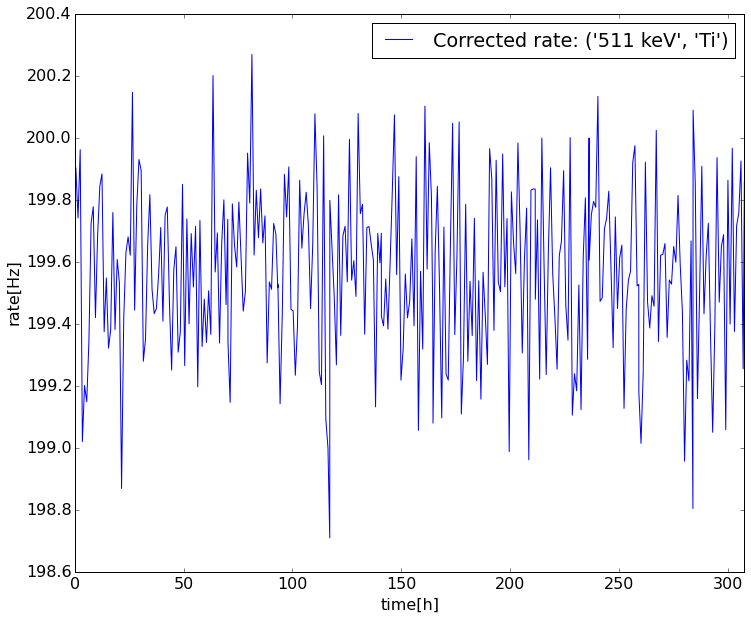

Half life time : 58.9 yr
A0 : 199.569014308 +- 0.0151728401973 Bq


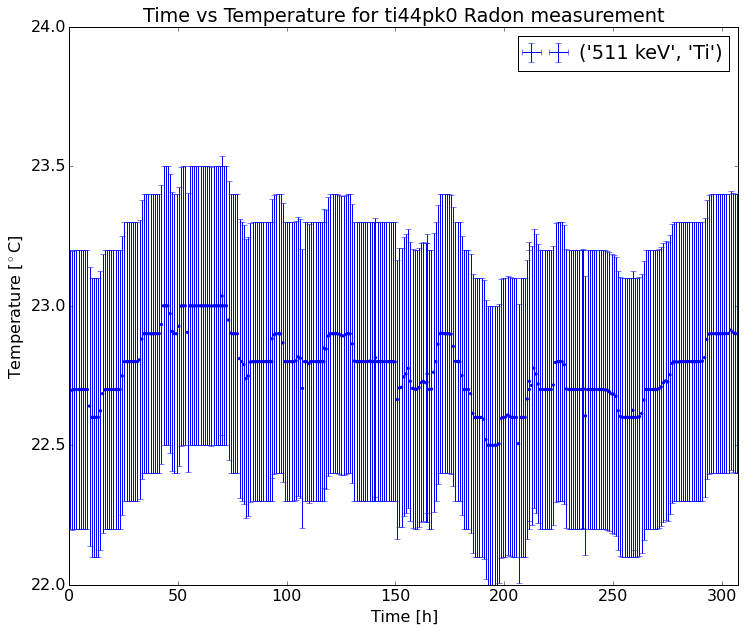

For ('1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 29.5267570028 +- 0.00697958108423 Bq


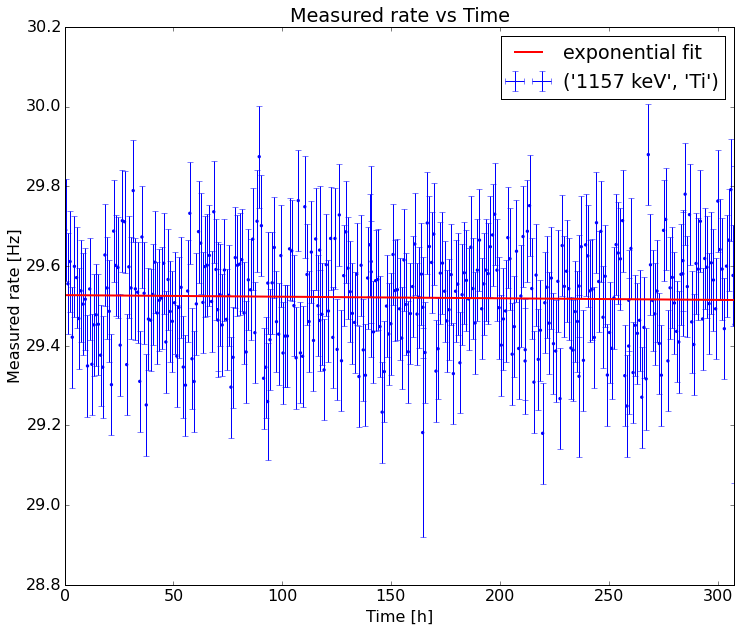

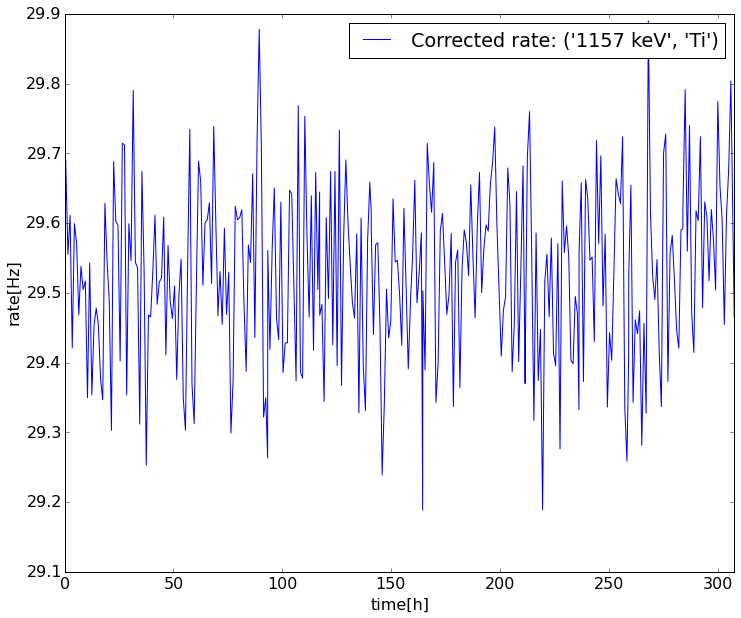

For ('511.+1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 21.5828926798 +- 0.00489161838331 Bq


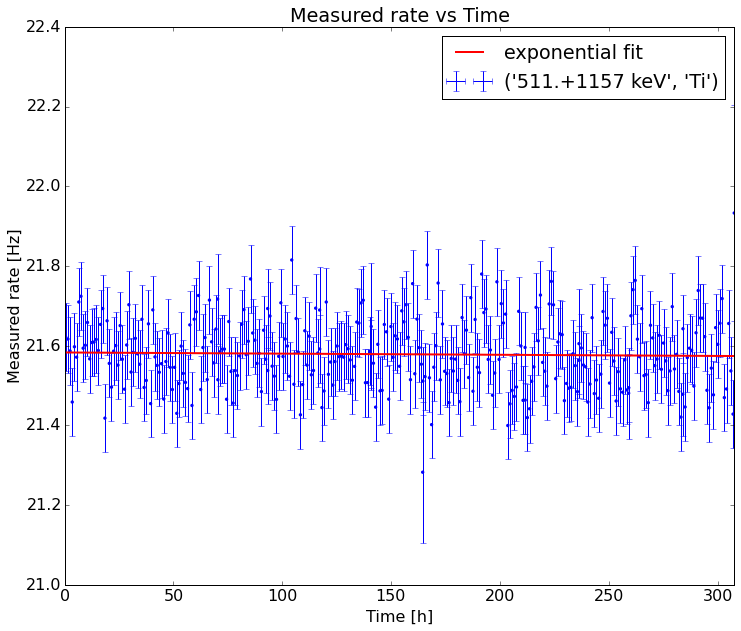

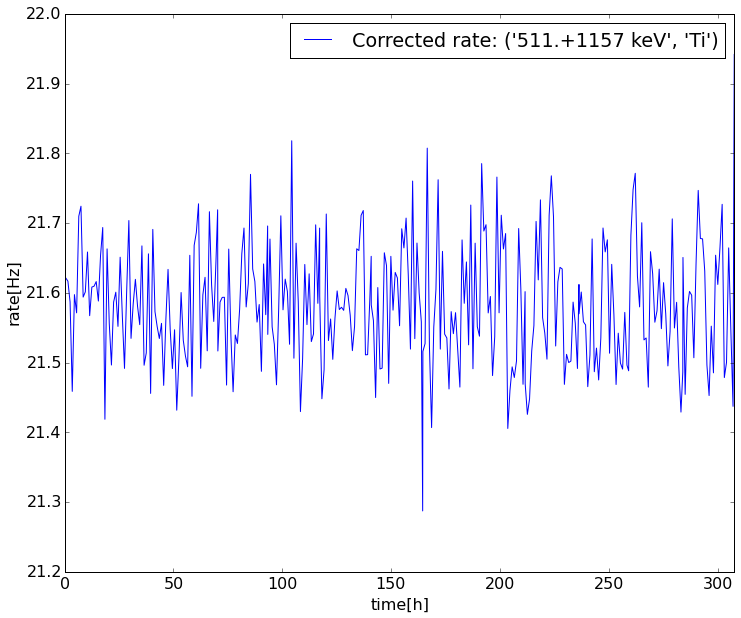

For ('511 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 199.935192793 +- 0.0157698532797 Bq


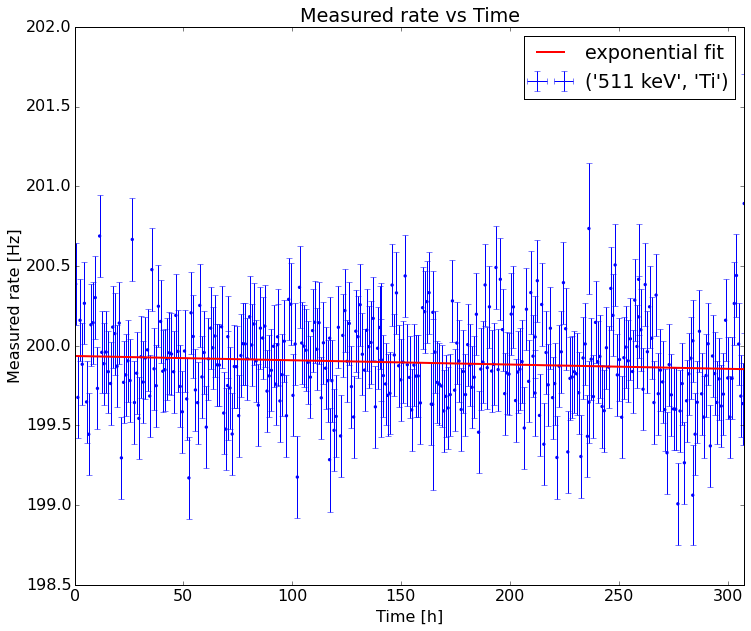

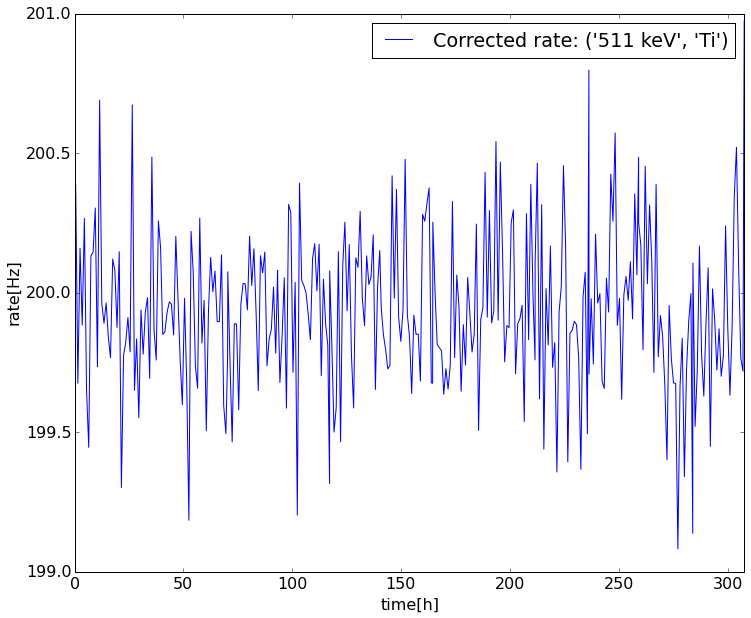

For ('1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 30.5358044482 +- 0.00730493260191 Bq


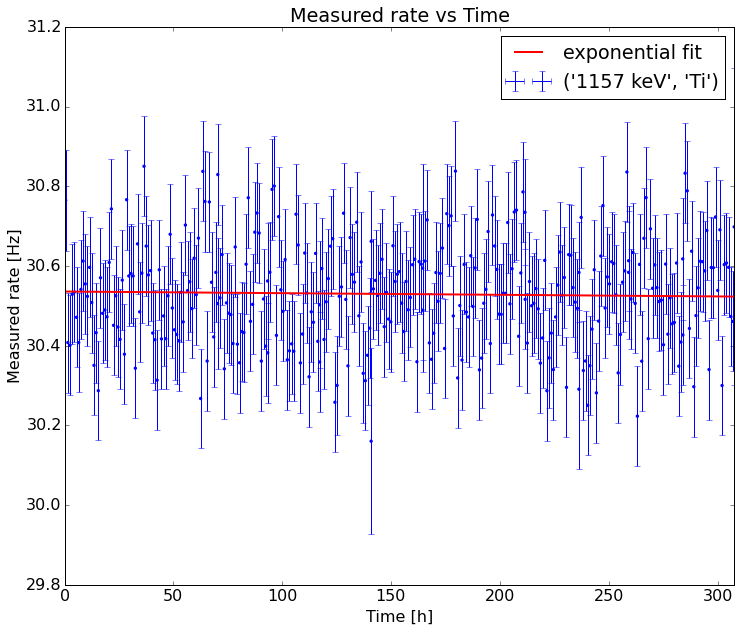

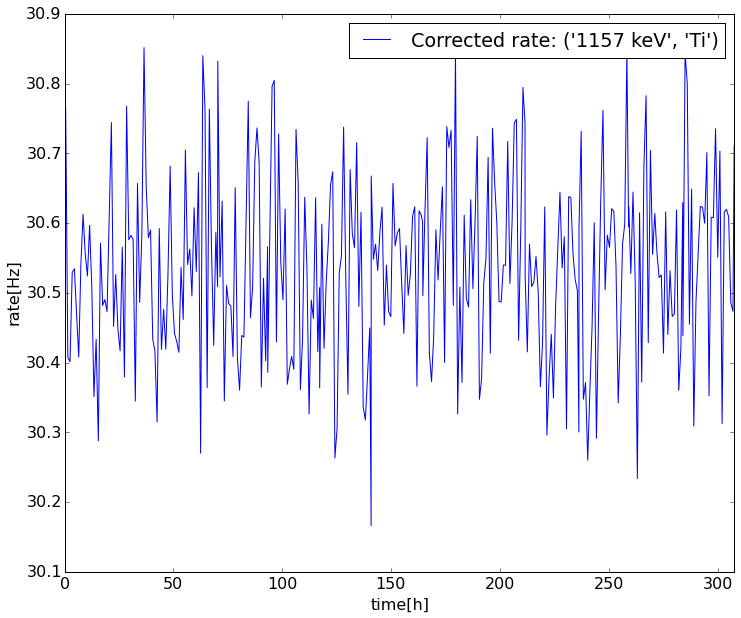

For ('511.+1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 22.7894073578 +- 0.0051577392058 Bq


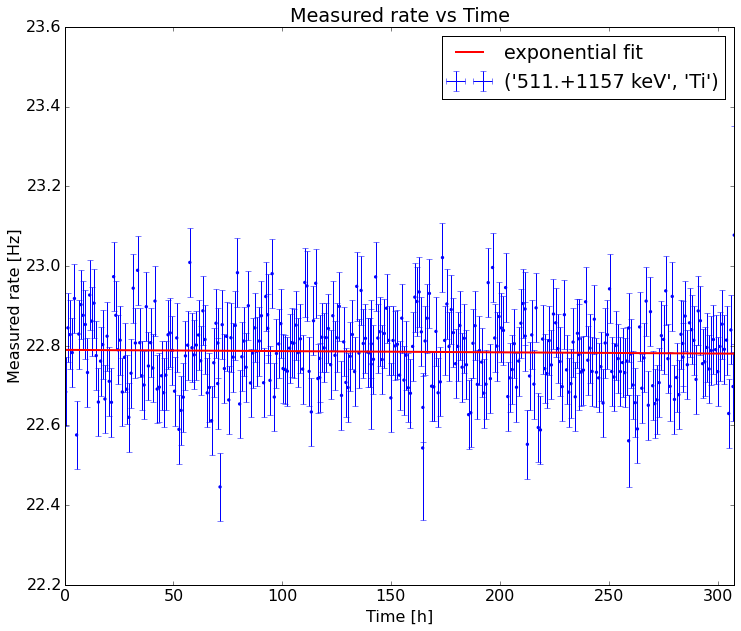

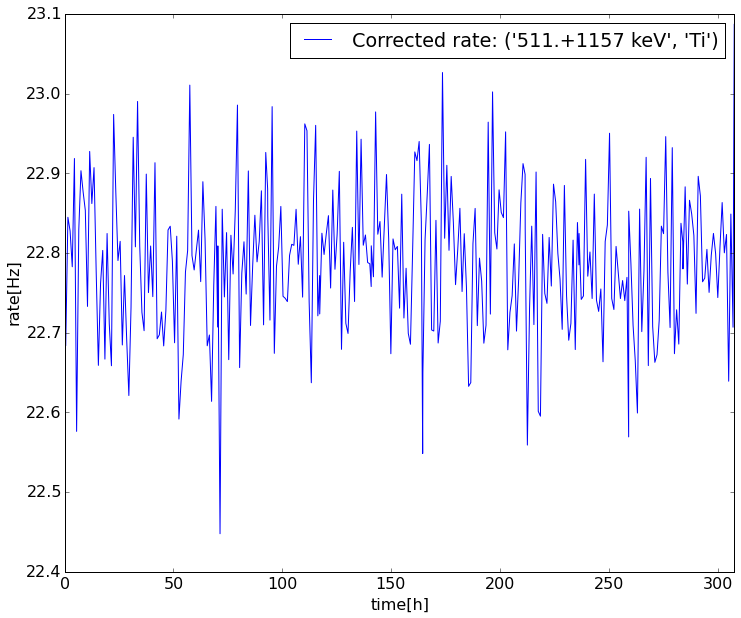

For ('1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 33.281136354 +- 0.00560368423053 Bq


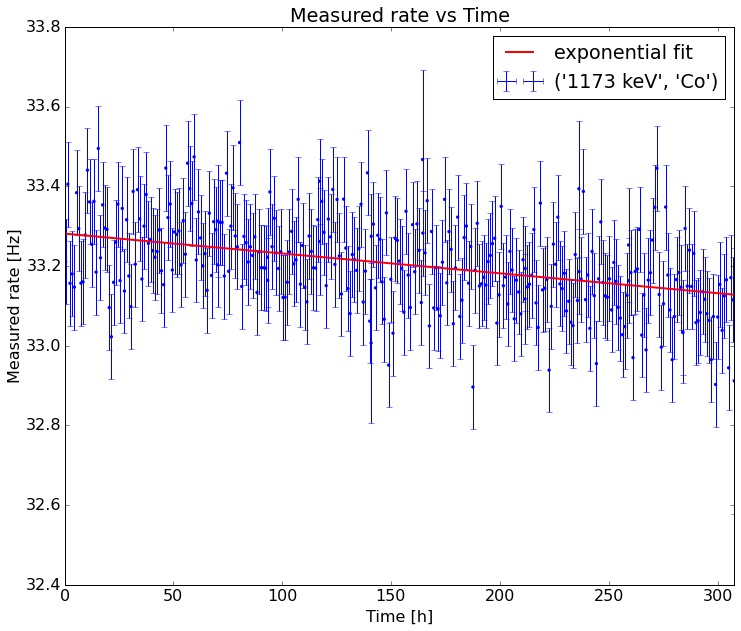

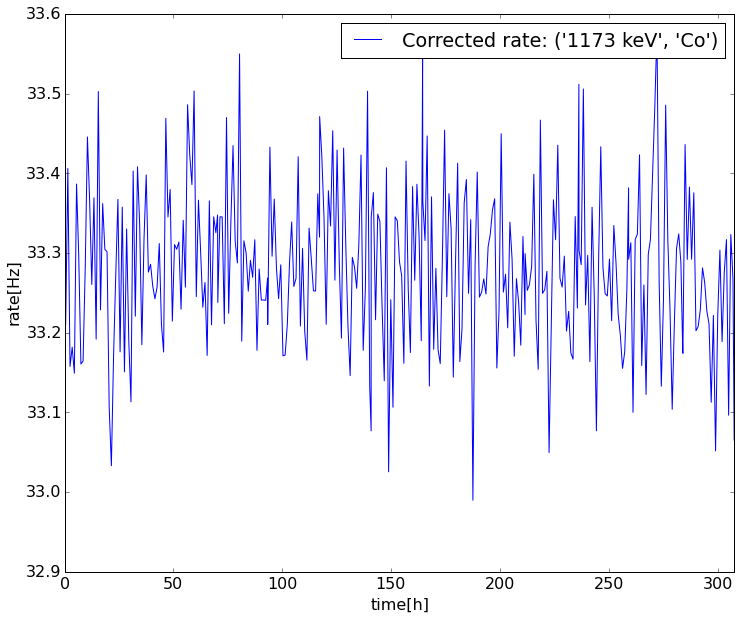

For ('1332 keV', 'Co'):
Half life time : 5.27 yr
A0 : 29.4024553908 +- 0.006022333702 Bq


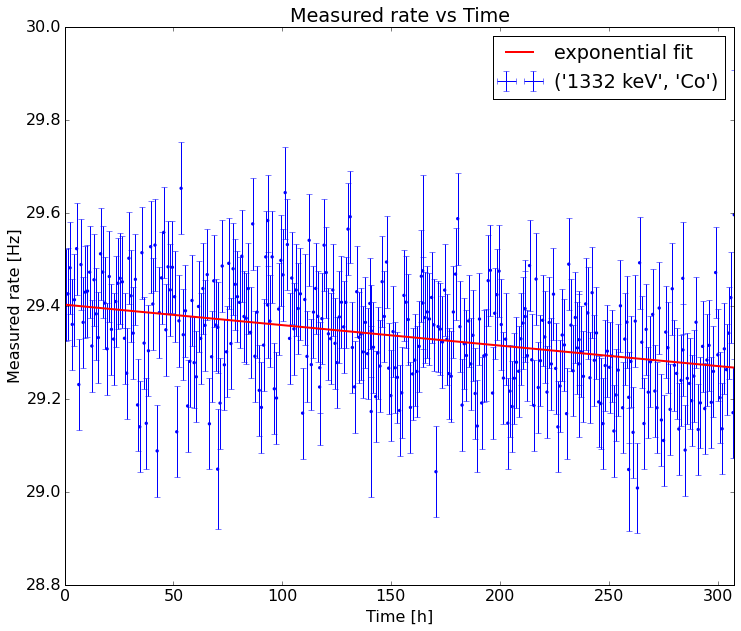

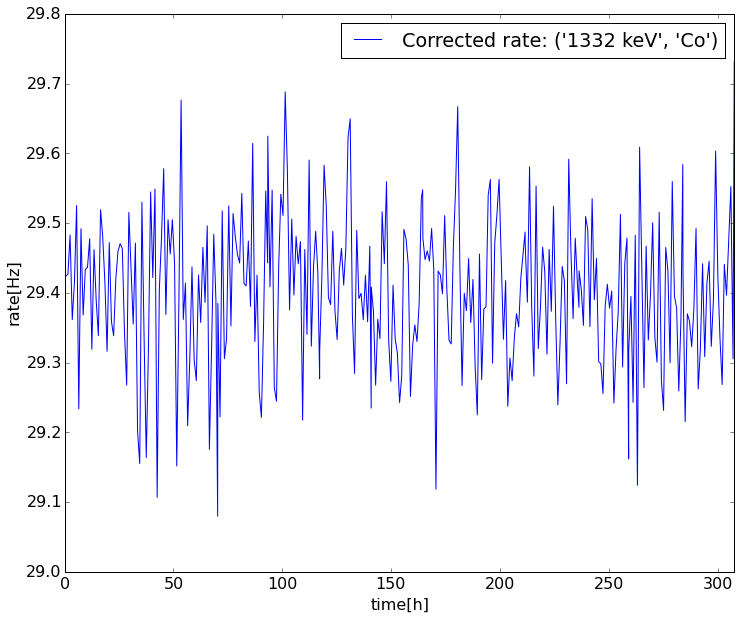

For ('1332 + 1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 3.54922407632 +- 0.00187234317744 Bq


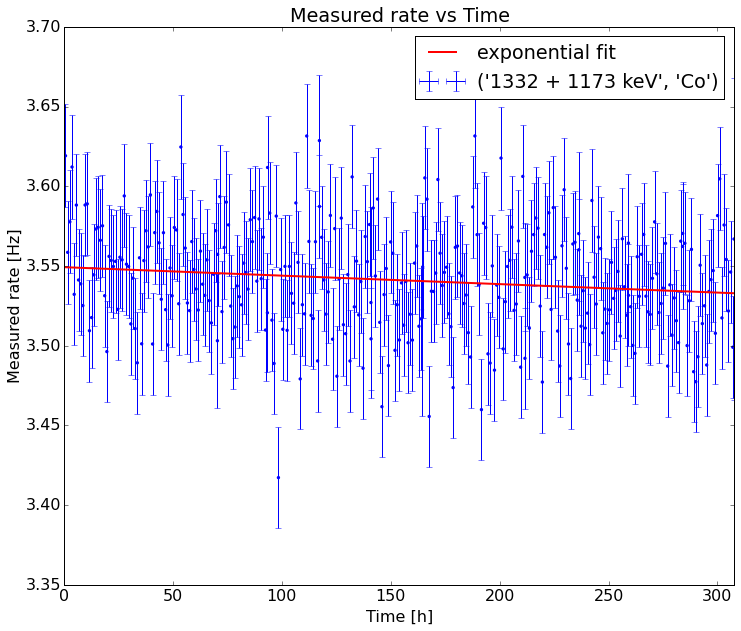

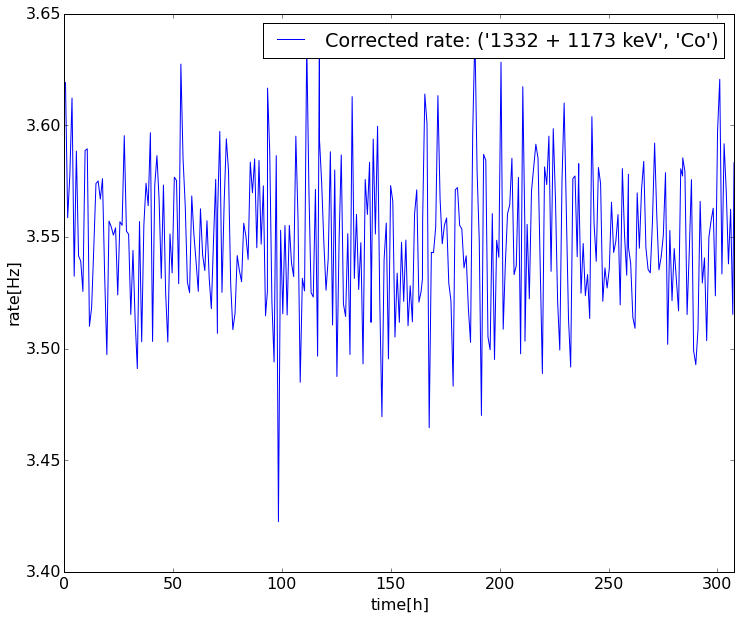

For ('1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 32.2386228408 +- 0.00608686085417 Bq


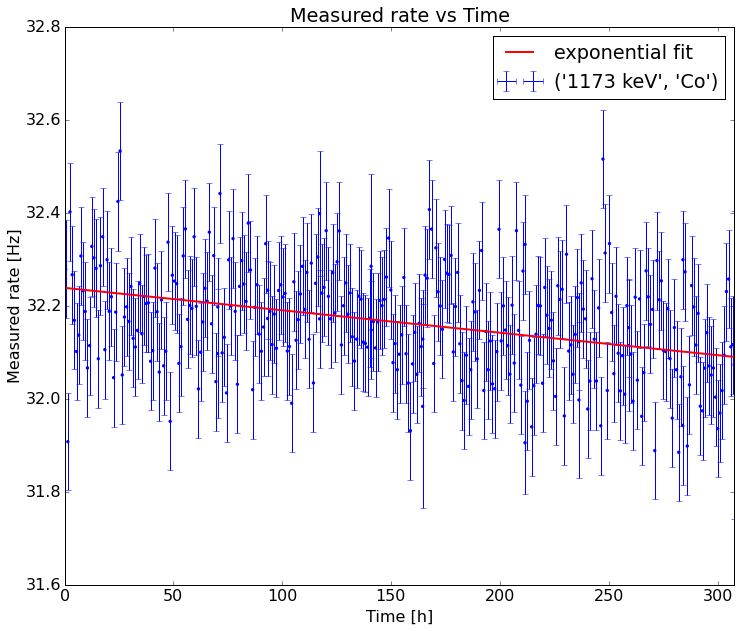

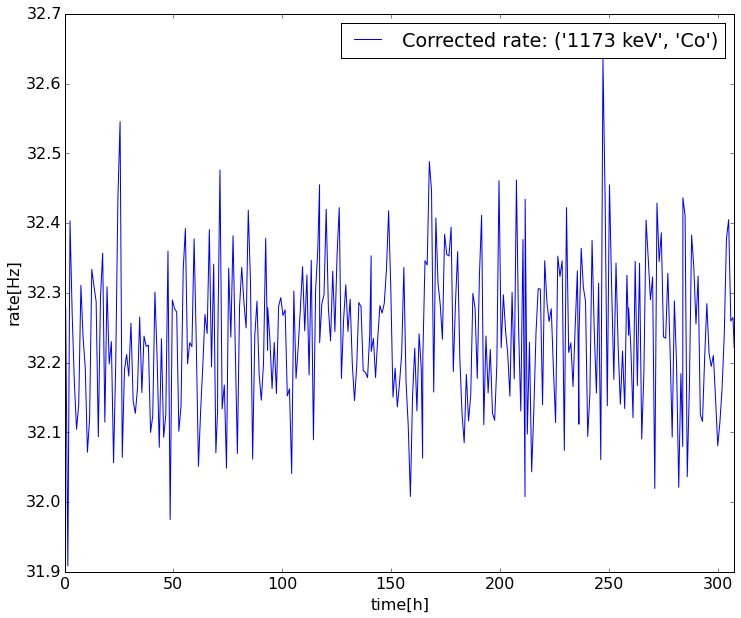

For ('1332 keV', 'Co'):
Half life time : 5.27 yr
A0 : 28.5772339613 +- 0.00616597771787 Bq


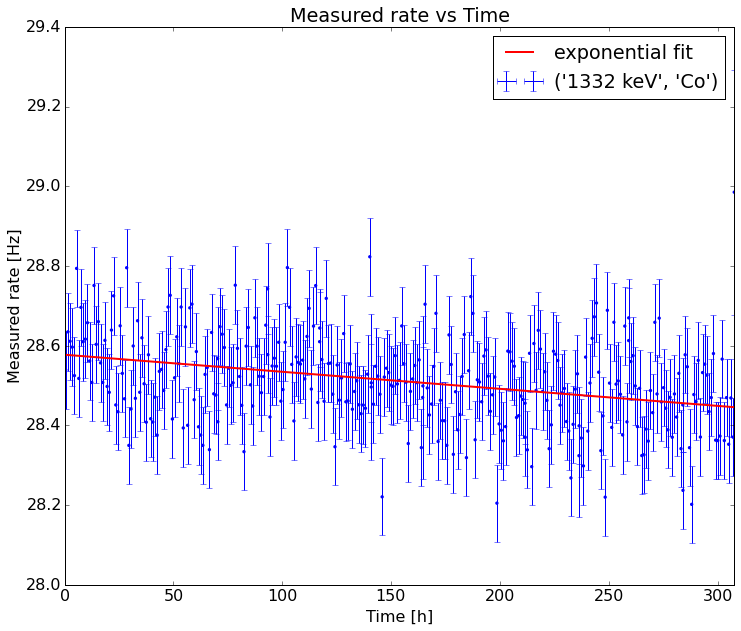

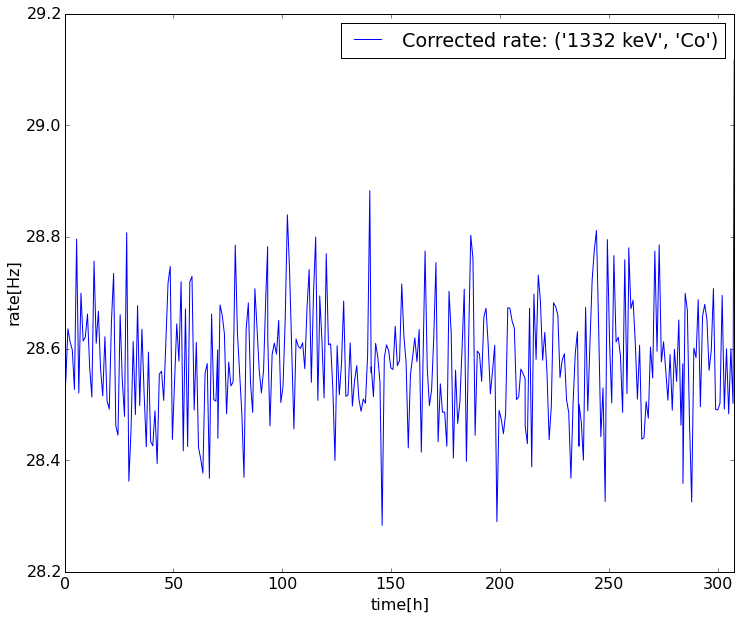

For ('1332 + 1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 3.24743757682 +- 0.00190422597802 Bq


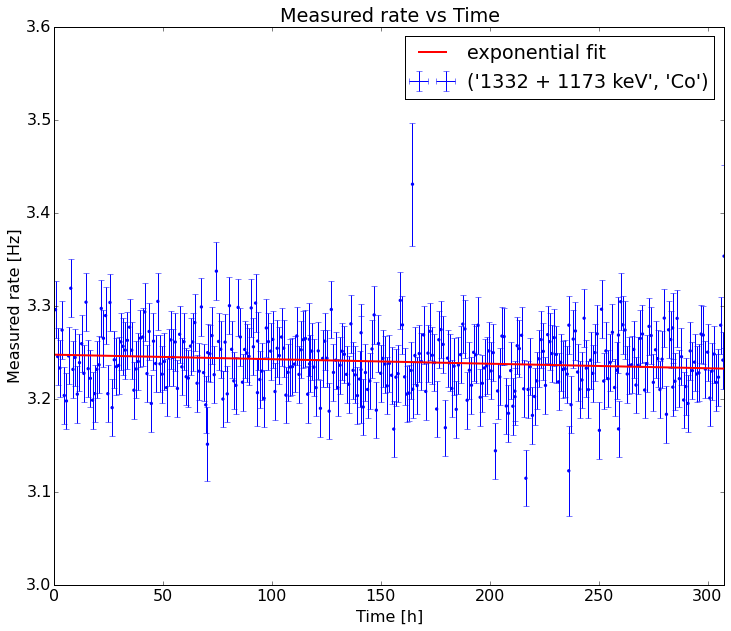

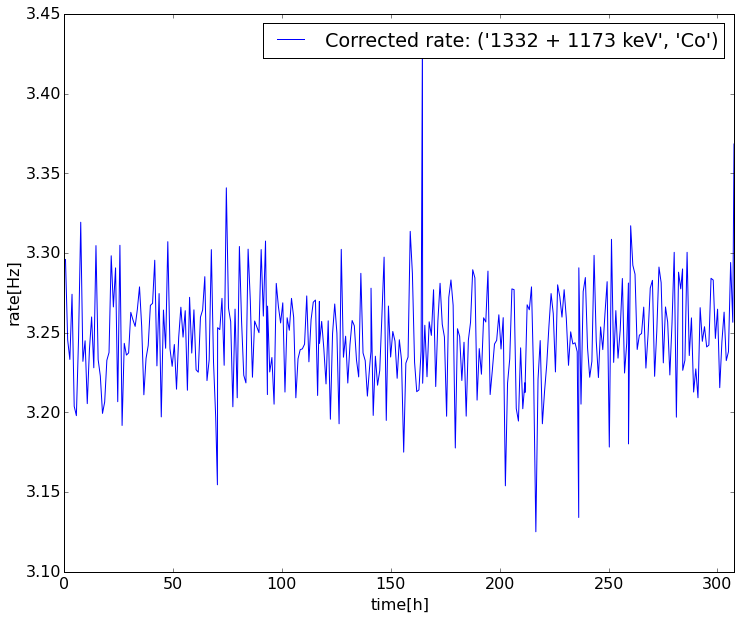

For ('662 keV', 'Cs'):
Half life time : 30.05 yr
A0 : 83.3995491805 +- 0.0094570107481 Bq


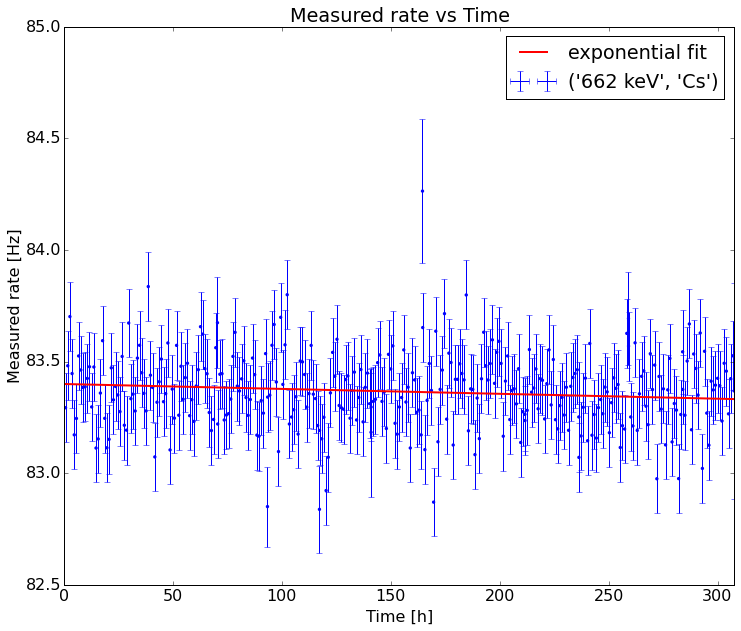

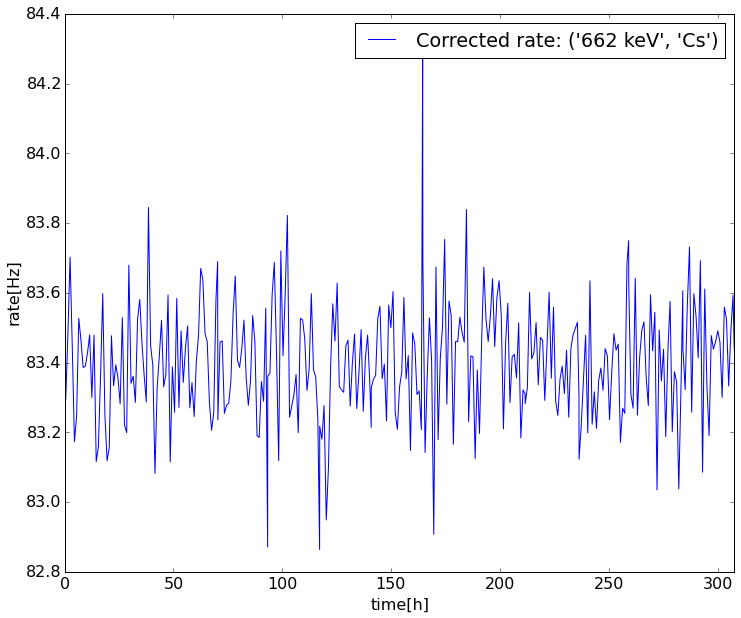

For ('662 keV', 'Cs'):
Half life time : 30.05 yr
A0 : 111.238838293 +- 0.00977441952011 Bq


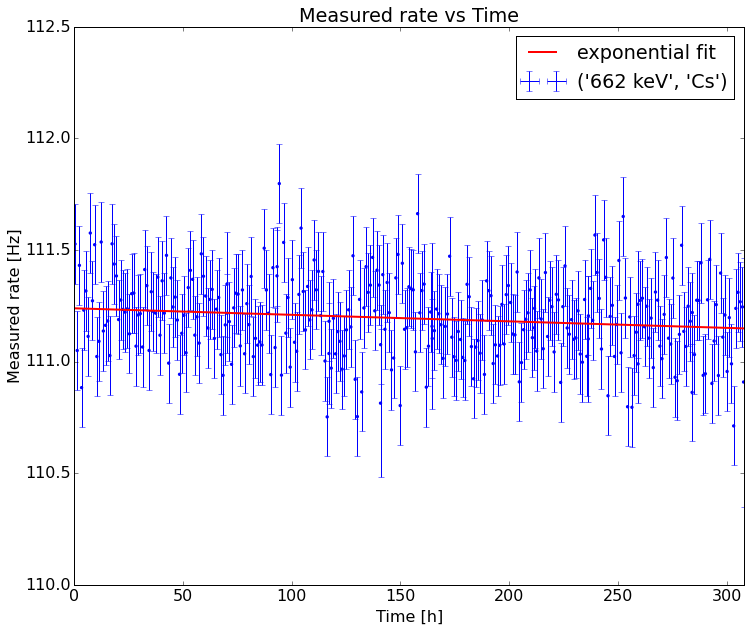

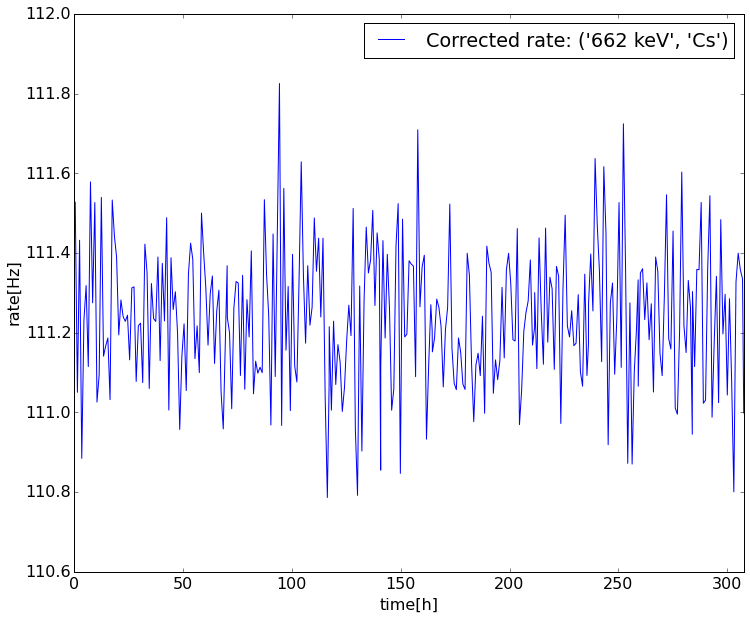

In [8]:
# Plot radon vs time: Get data, organize and average data and determine and caculate errors
data = recursive_defaultdict()
lists = recursive_defaultdict()

for (channel_i, peak_i), peakd in datas.groupby(['channel','peak']):
    rate = peakd['rate']
    drate = peakd['drate'] # error on rate according to dataset (thus from AP's code)
    time = data_time_hours
    radon = radonAr
    dradon = dradonAr
    temp = peakd['temp']

    # for every channel and peak combination fill lists with data
    lists['rate']['value'] = np.array(rate)
    lists['time']['value'] = np.array(time)
    lists['radon']['value'] = np.array(radon)
    lists['temp']['value'] = np.array(temp)
    
    # add errors    
    # Each datapoint is 1 hour of data
    lists['rate']['error'] = np.array(drate)
    lists['time']['error'] = [0.00000000001*60*60]*len(time) # just very, very small
    lists['radon']['error'] = np.array(dradon)
    lists['temp']['error'] = [0.5]*len(temp)
        
    # Define fit-function. Use half life time from literature
    if channel_i == 0 or channel_i == 1:
        half_life_time = (1.251*10**9)*365.25*24*60*60.
    elif channel_i == 2 or channel_i == 3:
        half_life_time = (58.9)*365.25*24*60*60.
    elif channel_i == 4 or channel_i == 5:
        half_life_time = (5.27)*365.25*24*60*60.
    elif channel_i == 6 or channel_i == 7:
        half_life_time = (30.05)*365.25*24*60*60.
    
    print("For %s:" % (fit_values[channel_i][peak_i],))
    # Determine first guess for A0(measured) and half-life
    guessA0 = max(lists['rate']['value']) #max value is presumably the activity at t=0 (since it only decreases)
    guessExp = (guessA0)
    
    # Now fit exponent to data
    found_fit_signal = fit_signal(lists['rate']['value'], guessExp, time)
    found_residual = residual(time, lists['rate']['value'], found_fit_signal[0])
    
    # plot rate vs time    
    plt.xlabel('Time [h]')
    plt.ylabel('Measured rate [Hz]')
    plt.errorbar(time, lists['rate']['value'], xerr=lists['time']['error'], yerr=lists['rate']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
    plt.scatter(time, lists['rate']['value'], marker='.', edgecolors='none', s=45)
    plt.plot(time, found_fit_signal[0], 'r', linewidth=2.0, label="exponential fit")
    plt.title('Measured rate vs Time')
    plt.xlim(0,max(time))   
    plt.legend()
    if channel_i == 2 and peak_i == 0:
        plt.savefig('rate_vs_time_fitEXP_Ti_511kev.png', format='png', dpi=300)
        plt.savefig('rate_vs_time_fitEXP_Ti_511kev.pdf', format='pdf', dpi=300)
    plt.show()
   
    # Calculate corrected rate:
    corr_rate = found_residual+found_fit_signal[1]
    plt.plot(time, corr_rate, label='Corrected rate: %s' %(fit_values[channel_i][peak_i],))
    plt.xlim(0, max(time))
    plt.xlabel('time[h]')
    plt.ylabel('rate[Hz]')
    plt.legend()
#     if channel_i == 2 and peak_i == 0:
#         plt.savefig('residual_Ti_511keV.png', format='png', dpi=300)
    plt.show()
    
    # For now: save only the arrays for the Ti-44 pk0 measurement.
    # Because we only need one to show the plot. 
    if channel_i == 2 and peak_i == 0:
        found_fit_signalTipk0 = fit_signal(lists['rate']['value'], guessExp, time)
        np.savetxt('ti44pk0_rate', (lists['rate']['value']))
        np.savetxt('ti44pk0_error_rate', (lists['rate']['error']))
        np.savetxt('ti44pk0_residual', (found_residual))
        np.savetxt('ti44pk0_foundFitA0_and_Error', (found_fit_signalTipk0[1], found_fit_signalTipk0[2]))
        np.savetxt('ti44pk0_corrected_rate', (found_residual+found_fit_signalTipk0[1]))
        np.savetxt('ti44pk0_time', (time))
        
        np.savetxt('ti44pk0_radon', (radon))
        np.savetxt('ti44pk0_error_radon', (dradon))
        
        np.savetxt('temperature_radon_measurement', (lists['temp']['value']))
        np.savetxt('temperature_error_radon_measurement', (lists['temp']['error']))
        
        
        # Slow control parameters temperature, pressure and humidity plotted.
        # Just to see whether strange things happen.
        # Time vs temperature
        plt.title('Time vs Temperature for ti44pk0 Radon measurement')
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [$^{\circ}$C]')
        plt.errorbar(time, lists['temp']['value'], xerr=lists['time']['error'], yerr=lists['temp']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
        plt.scatter(time, lists['temp']['value'], marker='.', edgecolors='none', s=45)
        plt.xlim(0,max(time))   
        plt.ylim(22,24)
        plt.legend()
        plt.show()
        
        
#         # Time vs radon
#         plt.xlabel('Time [h]')
#         plt.ylabel('Radon [Bq/m$^3$]')
#         plt.errorbar(time, radon, xerr=lists['time']['error'], yerr=lists['radon']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
#         plt.scatter(time, radon, marker='.', edgecolors='none', s=45)
#         plt.title('Radon concentration vs time')
#         plt.xlim(0,max(time))   
#         plt.ylim(21,33)
#         plt.legend()
#         plt.show()


In [5]:
# Test with 1 Rad7 datafile (time and Rn concentration in Bq/m3)
# time of Rad7 is in month/day/year and hour:minute whereas LabView counts in seconds
# 222Rn is measured at one place in the inner box, 
# so it is the same for all sources as far as this measurement is concerned 

dateTime = []
radon = []
dradon = []

# data = open("RAD7 3072 2016-06-26onlyRnANDtime.txt")

with open("RAD7 3072 2016-06-26onlyRnANDtime.txt", 'r') as data:
    data0626 = data.readlines()
    for line in data0626:
        data_split = line.split(",")
        dateTime.append(data_split[0])
        radon.append(float(data_split[1]))
        dradon.append(float(data_split[2]))
len(dradon)

24